In [181]:
import pandas as pd

df = pd.read_csv(r'C:\Users\ali.karimi\Documents\JupyterProjects\NextPurchaseAmount\online_retail_II.xlsx~\cleaned_adjusted_online_retail.csv')


print (df.shape)
df.head()


(254935, 10)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,OrigQuantity,AdjustedQuantity
0,529924,22698,pink regency teacup and saucer,6,2010-10-31 14:20:00,2.95,12347,Iceland,6,6
1,529924,22699,roses regency teacup and saucer,6,2010-10-31 14:20:00,2.95,12347,Iceland,6,6
2,529924,20985,heart calculator,12,2010-10-31 14:20:00,1.25,12347,Iceland,12,12
3,529924,22418,10 colour spaceboy pen,24,2010-10-31 14:20:00,0.85,12347,Iceland,24,24
4,529924,22422,toothpaste tube pen,12,2010-10-31 14:20:00,0.65,12347,Iceland,12,12


In [182]:
df['Quantity']=df['AdjustedQuantity']
df.drop(['AdjustedQuantity', 'OrigQuantity'], axis=1, inplace=True )



In [184]:
df['Amount']=df['Quantity']*df['Price']

# invoice_df= df.groupby(['Invoice','Customer ID', 'DaysSince', 'InvoiceDate'], as_index=False).agg({'Amount':'sum','Quantity':'sum'})
# invoice_df.head()

# invoice_df.describe()


In [229]:

import numpy as np

def summarize_customer_history_no_leak_with_label_fixed(df,
                                                        customer_col='CustomerID',
                                                        date_col='InvoiceDate',
                                                        invoice_col='Invoice',
                                                        amount_col='Amount',
                                                        qty_col='Quantity',
                                                        stock_col='StockCode',
                                                        label_days=30,
                                                        reference_date=None):
    """
    Returns (feat_df, targets)
    - feat_df: features computed ONLY from purchases BEFORE the penultimate invoice (anchor).
    - targets: last two invoice info + label_next_<label_days>d (1/0 or NaN if <2 invoices).
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df[qty_col] = pd.to_numeric(df[qty_col], errors='coerce').fillna(0)
    df[amount_col] = pd.to_numeric(df[amount_col], errors='coerce').fillna(0.0)
    df[stock_col] = df[stock_col].astype(str)

    if reference_date is None:
        reference_date = df[date_col].max()
    reference_date = pd.to_datetime(reference_date)

    feat_rows = []
    target_rows = []

    # invoice-level aggregation once for speed
    inv_level = df.groupby([customer_col, invoice_col]).agg({date_col: 'max'}).reset_index()

    for cust, g in df.groupby(customer_col, sort=False):
        g = g.sort_values(date_col)
        # positive purchases only
        purchases = g[(g[amount_col] > 0) | (g[qty_col] > 0)].copy()

        # invoice-level for this customer
        invs = inv_level[inv_level[customer_col] == cust].sort_values(date_col)
        if len(invs) < 2:
            # cannot build label
            feat_rows.append({customer_col: cust})
            target_rows.append({
                customer_col: cust,
                'anchor_invoice': np.nan,
                'anchor_date': pd.NaT,
                'next_invoice': np.nan,
                'next_date': pd.NaT,
                f'label_next_{label_days}d': np.nan
            })
            continue

        # identify anchor (penultimate) and next (last) at invoice-level (robust)
        anchor_inv = invs.iloc[-2][invoice_col]
        anchor_date = pd.to_datetime(invs.iloc[-2][date_col])
        next_inv = invs.iloc[-1][invoice_col]
        next_date = pd.to_datetime(invs.iloc[-1][date_col])

        # label: whether next is within label_days after anchor
        label = 1 if (next_date - anchor_date).days <= label_days else 0

        target_rows.append({
            customer_col: cust,
            'anchor_invoice': anchor_inv,
            'anchor_date': anchor_date,
            'next_invoice': next_inv,
            'next_date': next_date,
            f'label_next_{label_days}d': label
        })

        # PRIOR = purchases strictly BEFORE anchor invoice (exclude anchor and anything after)
        # determine invoice ids before anchor
        invs_before_anchor = invs.iloc[:-2][invoice_col].tolist()  # may be empty
        if invs_before_anchor:
            prior = purchases[purchases[invoice_col].isin(invs_before_anchor)].copy()
        else:
            prior = purchases.iloc[0:0].copy()  # empty with same columns

        # compute features on prior (safe if prior empty)
        num_rows = len(g)
        num_purchases_prior = len(invs_before_anchor)
        total_amount = float(prior[amount_col].sum()) if not prior.empty else 0.0
        total_quantity = float(prior[qty_col].sum()) if not prior.empty else 0.0
        avg_amount = float(prior[amount_col].mean()) if not prior.empty else np.nan
        median_amount = float(prior[amount_col].median()) if not prior.empty else np.nan
        std_amount = float(prior[amount_col].std()) if not prior.empty else np.nan
        min_amount = float(prior[amount_col].min()) if not prior.empty else np.nan
        max_amount = float(prior[amount_col].max()) if not prior.empty else np.nan

        first_date = prior[date_col].min() if not prior.empty else pd.NaT
        last_date_prior = prior[date_col].max() if not prior.empty else pd.NaT
        recency_days = (reference_date - last_date_prior).days if pd.notna(last_date_prior) else np.nan
        tenure_days = (reference_date - first_date).days if pd.notna(first_date) else np.nan

        if not prior.empty:
            inv_agg = prior.groupby(invoice_col).agg({date_col: 'max', amount_col: 'sum'}).sort_values(date_col)
            inv_dates = inv_agg[date_col]
            interdays = inv_dates.diff().dt.days.dropna()
            avg_inter = float(interdays.mean()) if not interdays.empty else np.nan
            std_inter = float(interdays.std()) if not interdays.empty else np.nan
            min_inter = float(interdays.min()) if not interdays.empty else np.nan
            max_inter = float(interdays.max()) if not interdays.empty else np.nan
            slope = np.nan
            if len(inv_agg) >= 2:
                x = inv_agg[date_col].map(lambda d: d.toordinal()).values
                y = inv_agg[amount_col].values
                if np.ptp(x) > 0:
                    slope = float(np.polyfit(x, y, 1)[0])
            last_amount_prior = float(inv_agg[amount_col].iloc[-1]) if len(inv_agg) >= 1 else np.nan
            last_3_avg = float(inv_agg[amount_col].tail(3).mean()) if len(inv_agg) >= 1 else np.nan
        else:
            avg_inter = std_inter = min_inter = max_inter = np.nan
            slope = np.nan
            last_amount_prior = np.nan
            last_3_avg = np.nan

        unique_items = prior[stock_col].nunique() if not prior.empty else 0
        total_item_rows = prior.shape[0]
        repeat_rate = 1 - (unique_items / total_item_rows) if total_item_rows > 0 else 0.0

        top1_share = 0.0
        if not prior.empty and total_amount > 0:
            by_item = prior.groupby(stock_col)[amount_col].sum()
            top1 = by_item.sort_values(ascending=False).iloc[0]
            top1_share = float(top1 / total_amount)

        months = prior[date_col].dt.month if not prior.empty else pd.Series(dtype=int)
        month_top = int(months.value_counts().idxmax()) if not months.empty else np.nan

        years = tenure_days / 365.25 if pd.notna(tenure_days) and tenure_days > 0 else np.nan
        freq_per_year = num_purchases_prior / years if years and years > 0 else np.nan

        q75 = prior[amount_col].quantile(0.75) if not prior.empty else np.nan
        high_value_pct = (prior[amount_col] > q75).mean() if not prior.empty else 0.0

        feat_rows.append({
            customer_col: cust,
            'num_rows': num_rows,
            'num_purchases_prior': num_purchases_prior,
            'total_amount_prior': total_amount,
            'total_quantity_prior': total_quantity,
            'avg_amount_prior': avg_amount,
            'median_amount_prior': median_amount,
            'std_amount_prior': std_amount,
            'min_amount_prior': min_amount,
            'max_amount_prior': max_amount,
            'last_amount_prior': last_amount_prior,
            #'first_purchase_date_prior': first_date,
            #'last_purchase_date_prior': last_date_prior,
            'recency_days_prior': recency_days,
            'tenure_days_prior': tenure_days,
            'avg_interpurchase_days': avg_inter,
            'std_interpurchase_days': std_inter,
            'min_interpurchase_days': min_inter,
            'max_interpurchase_days': max_inter,
            'unique_items_prior': unique_items,
            'repeat_rate_prior': repeat_rate,
            'top1_item_share_prior': top1_share,
            'month_top_prior': month_top,
            'amount_trend_slope_prior': slope,
            'last_3_avg_amount_prior': last_3_avg,
            'freq_per_year_prior': freq_per_year,
            'high_value_pct_prior': high_value_pct
        })

    feat_df = pd.DataFrame(feat_rows)
    targets = pd.DataFrame(target_rows)
    return feat_df, targets


In [230]:
X,y = summarize_customer_history_no_leak_with_label_fixed(df,
                                      customer_col='Customer ID',
                                      date_col='InvoiceDate',
                                      invoice_col='Invoice',
                                      amount_col='Amount',
                                      qty_col='Quantity',
                                      stock_col='StockCode',
                                      label_days=30,
                                      reference_date=pd.Timestamp('2012-01-01'))

In [231]:
mask_too_many_nulls = X.isnull().mean(axis=1) > 0.5

customer_ids_removed = X.loc[mask_too_many_nulls, 'Customer ID'].tolist()

X = X.loc[~mask_too_many_nulls].reset_index(drop=True)
y = y.loc[~mask_too_many_nulls].reset_index(drop=True)

print("New X shape:", X.shape)
print("New y shape:", y.shape)
        



y['label_next_30d'].value_counts()

New X shape: (1590, 25)
New y shape: (1590, 6)


label_next_30d
0.0    831
1.0    759
Name: count, dtype: int64

In [232]:
X=X.loc[:,X.isnull().mean()<0.5]

X.isnull().mean()



Customer ID                 0.000000
num_rows                    0.000000
num_purchases_prior         0.000000
total_amount_prior          0.000000
total_quantity_prior        0.000000
avg_amount_prior            0.000000
median_amount_prior         0.000000
std_amount_prior            0.009434
min_amount_prior            0.000000
max_amount_prior            0.000000
last_amount_prior           0.000000
recency_days_prior          0.000000
tenure_days_prior           0.000000
avg_interpurchase_days      0.281132
std_interpurchase_days      0.476730
min_interpurchase_days      0.281132
max_interpurchase_days      0.281132
unique_items_prior          0.000000
repeat_rate_prior           0.000000
top1_item_share_prior       0.000000
month_top_prior             0.000000
amount_trend_slope_prior    0.296855
last_3_avg_amount_prior     0.000000
freq_per_year_prior         0.000000
high_value_pct_prior        0.000000
dtype: float64

In [233]:
X=X.sort_values(['Customer ID'])
y=y.sort_values(['Customer ID'])

#چک کنم که که هر کاستومر آیدی که تو ایکس هست تو وای هم هست به همون ترتیب
for i in range(len(X)):
    if X['Customer ID'].iloc[i]!=y['Customer ID'].iloc[i]:
        print (i)

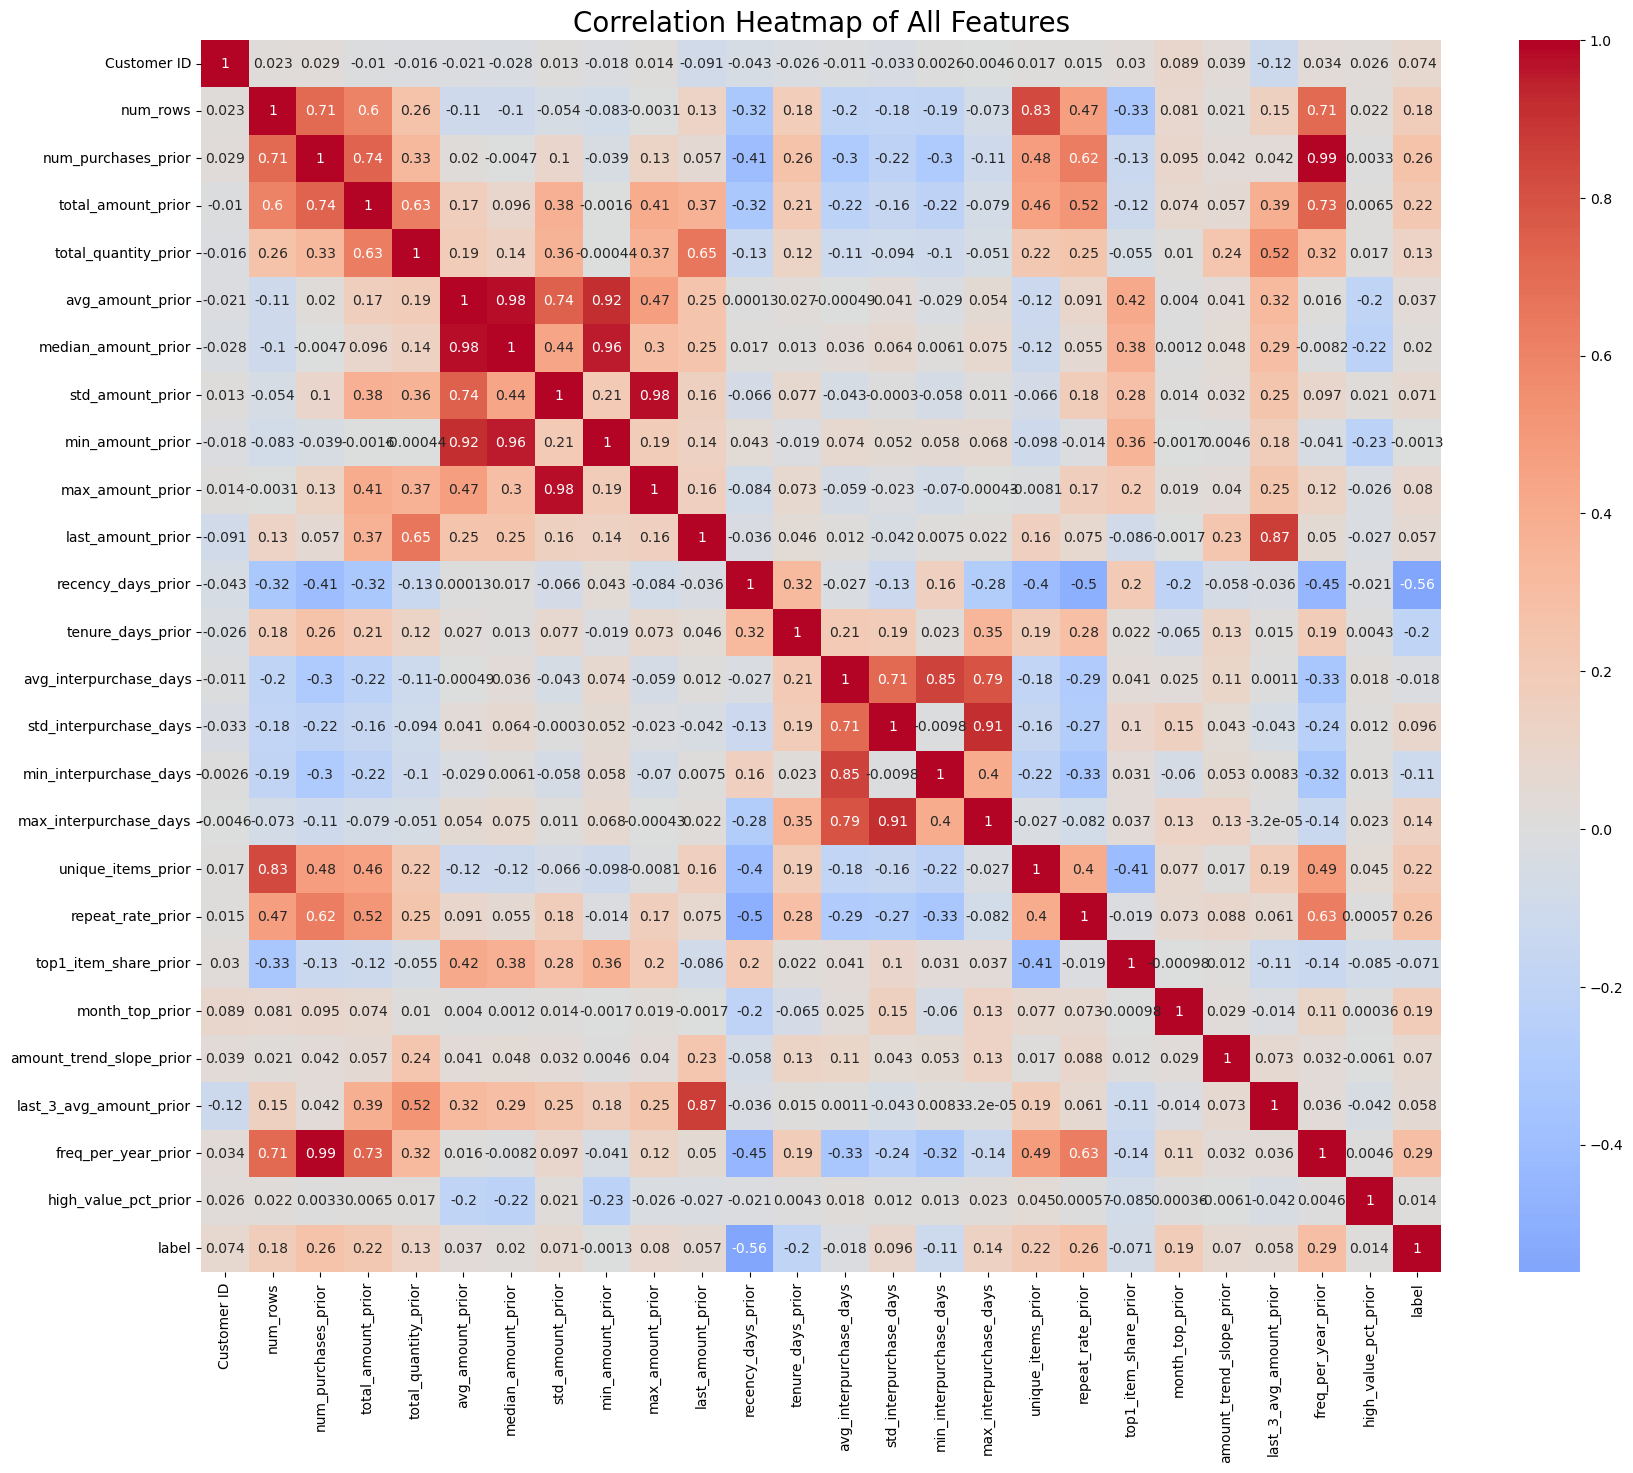

In [262]:
import matplotlib.pyplot as plt
import seaborn as sns

df_all = X.copy()
df_all['label'] = y['label_next_30d']


plt.figure(figsize=(20, 16))
sns.heatmap(df_all.corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of All Features", fontsize=20)
plt.show()

In [266]:
import pandas as pd
import numpy as np

# فرض: df_all شامل همه فیچرها + ستون 'label'
corr_matrix = df_all.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = []
label_col = 'label'

for col in upper.columns:
    # پیدا کردن ستون‌هایی که با col همبستگی بالای 0.7 دارند
    high_corr = [row for row in upper.index if upper.loc[row, col] > 0.7]
    for row in high_corr:
        # مقایسه correlation با label
        c1 = abs(df_all[col].corr(df_all[label_col]))
        c2 = abs(df_all[row].corr(df_all[label_col]))
        if c1 >= c2:
            to_drop.append(row)
        else:
            to_drop.append(col)

# حذف ستون‌های تکراری
to_drop = list(set(to_drop))
df_all_reduced = df_all.drop(columns=to_drop)

df_all_reduced.columns

            

Index(['Customer ID', 'total_quantity_prior', 'max_amount_prior',
       'recency_days_prior', 'tenure_days_prior', 'min_interpurchase_days',
       'max_interpurchase_days', 'unique_items_prior', 'repeat_rate_prior',
       'top1_item_share_prior', 'month_top_prior', 'amount_trend_slope_prior',
       'last_3_avg_amount_prior', 'freq_per_year_prior',
       'high_value_pct_prior', 'label'],
      dtype='object')

In [346]:
from sklearn.model_selection import train_test_split

X1=df_all_reduced.iloc[:,1:15]
y_NPT=df_all['label']
X_train,X_test,y_train,y_test=train_test_split(X1,y_NPT,train_size=0.85
                                               ,shuffle=True, random_state= 42)
X_train.columns


Index(['total_quantity_prior', 'max_amount_prior', 'recency_days_prior',
       'tenure_days_prior', 'min_interpurchase_days', 'max_interpurchase_days',
       'unique_items_prior', 'repeat_rate_prior', 'top1_item_share_prior',
       'month_top_prior', 'amount_trend_slope_prior',
       'last_3_avg_amount_prior', 'freq_per_year_prior',
       'high_value_pct_prior'],
      dtype='object')

In [306]:
y_train.value_counts()

label
0.0    672
1.0    600
Name: count, dtype: int64

In [383]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.14,
    max_depth=3,
    subsample=0.90,
    max_leaves=5,
    reg_alpha=0.7,
    reg_lambda=0.7,
    random_state=42,
    eval_metric="logloss"
)

model.fit(X_train, y_train)

y_pred_train=model.predict(X_train)
y_pred = model.predict(X_test)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred)

print("accuracy_train:", 100*round(accuracy_train,2),'%')
print("accuracy_test:", 100*round(accuracy_test,2),'%')

print("\n","\n",classification_report(y_test, y_pred))



accuracy_train: 84.0 %
accuracy_test: 80.0 %

 
               precision    recall  f1-score   support

         0.0       0.75      0.91      0.82       121
         1.0       0.88      0.69      0.77       118

    accuracy                           0.80       239
   macro avg       0.81      0.80      0.80       239
weighted avg       0.81      0.80      0.80       239



                     feature  importance
2         recency_days_prior    0.415853
3          tenure_days_prior    0.088634
0       total_quantity_prior    0.051068
4     min_interpurchase_days    0.047248
5     max_interpurchase_days    0.046402
11   last_3_avg_amount_prior    0.045737
9            month_top_prior    0.042674
1           max_amount_prior    0.041498
12       freq_per_year_prior    0.040532
8      top1_item_share_prior    0.039757
13      high_value_pct_prior    0.038055
7          repeat_rate_prior    0.037034
10  amount_trend_slope_prior    0.035342
6         unique_items_prior    0.030165


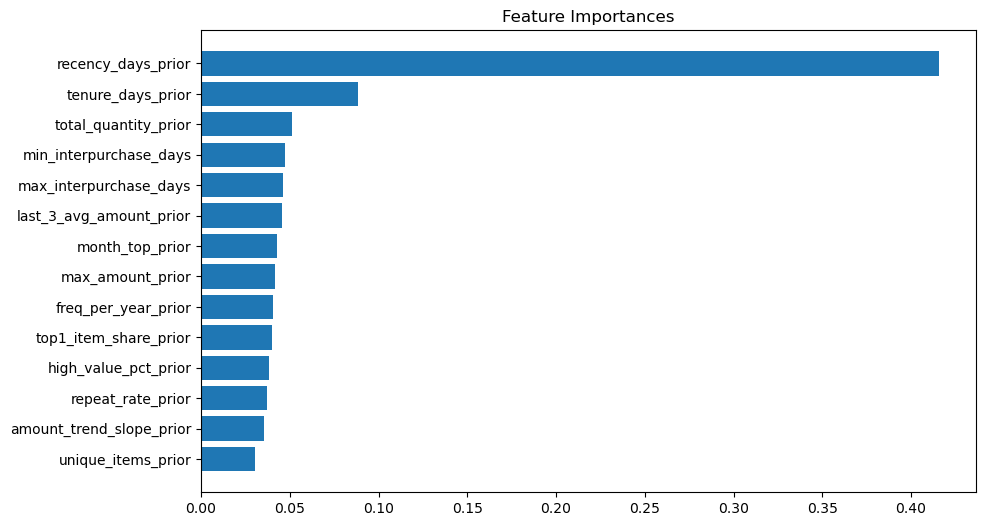

In [387]:
import pandas as pd
import matplotlib.pyplot as plt

# فرض کن model همون مدل آموزش دیده باشه
importances = model.feature_importances_
feat_names = X_train.columns
feat_imp = pd.DataFrame({'feature': feat_names, 'importance': importances})
feat_imp = feat_imp.sort_values(by='importance', ascending=False)

# نمایش برترین‌ها
print(feat_imp.head(20))

# یا بصری
plt.figure(figsize=(10,6))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importances")
plt.show()